<a href="https://colab.research.google.com/github/ABD-01/MNIST/blob/main/Triplet%20Loss/TRIPLET_LOSS_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations 
from tqdm import tqdm

import tensorflow as tf
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision
import torchvision.transforms as transforms

In [ ]:
# plt.rcParams['figure.figsize'] = (5, 5)

# Utils

In [ ]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [ ]:
def tf_triplet_loss(anchor, positive, negative, margin=0.2):  
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0)
    return tf.reduce_mean(loss)
 
# ref : https://stackoverflow.com/questions/38260113/implementing-contrastive-loss-and-triplet-loss-in-tensorflow/38270293#38270293

In [ ]:
torch_triplet_loss = nn.TripletMarginLoss(margin=0.2)

In [ ]:
def get_all_triplets(embeddings:list, targets:list) -> list:
    '''
    Parameters
    ----------
    embeddings : list of torch.tensor
    targets    : list of ints

    Returns
    -------
    triplets   : list of tuple
    '''

    # eg : no(targets) = 3
    # eg : no(embeds) = 10

    assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, anchor in enumerate(embeddings):

        positive_pairs = list(combinations(anchor,2))  # this will give of distinct pairs of elements 
                                                                 # no(pos_pairs) = no(targets)P2 / 2!  # eg : 45
        
        temp = embeddings.pop(i)  # embeddings list except the anchor
        for negative_embeddings in torch.cat(embeddings,dim=0):   # loops runs for no(targets)-1 * no(embeds) times  # eg : (3-1)*10=20 
            
            triple = [(positive_pair[0], positive_pair[1], negative_embeddings) for positive_pair in positive_pairs]  # no(triple) = n(pos_pair) # eg: 45
            
            triplets.extend(triple)   # no. of triplets added = no(pos_pairs)*(no(targets) - 1)*(no(embeds))  # eg: 45*2*10=900

        embeddings.insert(i, temp)

    return triplets  # no(triplets) = no(added_triples) * no(embeds) # eg: 900*3 = 2700

# ref : A lot can't even even mention here

In [ ]:
def get_all_tensor_triplets(embeddings:list, targets:list) -> torch.Tensor:
    '''
    Parameters
    ----------
    embeddings : list of torch.tensor each of shape torch.Size([?, 128])
    targets    : list of ints

    Returns
    -------
    triplets   : torch.tensor of shape torch.Size([?, no(triplets), 3])
    '''

    # eg : no(targets) = 3
    # eg : no(embeds) = 10

    assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, anchor in enumerate(embeddings):

        positive_pairs = list(combinations(anchor,2))  # this will give of distinct pairs of elements 
                                                                 # no(pos_pairs) = no(targets)P2 / 2!  # eg : 45
        
        temp = embeddings.pop(i)  # embeddings list except the anchor
        for negative_embeddings in torch.cat(embeddings,dim=0):   # loops runs for no(targets)-1 * no(embeds) times  # eg : (3-1)*10=20 
            
            triple = [torch.stack([positive_pair[0], positive_pair[1], negative_embeddings], dim=0) for positive_pair in positive_pairs]  # no(triple) = n(pos_pair) # eg: 45
            
            triplets.extend(triple)   # no. of triplets added = no(pos_pairs)*(no(targets) - 1)*(no(embeds))  # eg: 45*2*10=900

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)  # no(triplets) = no(added_triples) * no(embeds) # eg: 900*3 = 2700

# ref : A lot can't even even mention here

In [ ]:
def get_random_triplets(embeddings:list,  targets:list) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.  
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes 
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets. 
    '''


    assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, embedding in enumerate(embeddings):
        temp = embeddings.pop(i)

        for anchor in embedding:
            positive = random.choice(embedding)

            for negatives in embeddings:
                negative = random.choice(negatives)

                triplets.append(torch.stack([anchor, positive, negative], dim=0))

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)  


In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
 
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(3):
        plt.scatter(embeddings[i].detach().numpy()[:,0],embeddings[i].detach().numpy()[:,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(targets)

# ref: https://github.com/adambielski/siamese-triplet/blob/master/Experiments_MNIST.ipynb

In [ ]:
MNIST_train = torchvision.datasets.MNIST(
    root = '/content/drive/MyDrive/Colab Notebooks/',
    download = True,
    train = True,
    transform = transforms.ToTensor()
)

In [ ]:
MNIST_train.data.shape

torch.Size([60000, 28, 28])

4

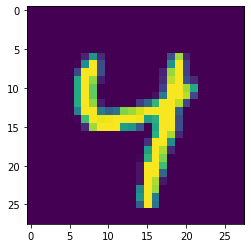

In [ ]:
i =5734
plt.imshow(MNIST_train[i][0].squeeze())
MNIST_train[i][1]

# Reorganizing Data

In [ ]:
train_dict = {i : MNIST_train.data[MNIST_train.targets == i].unsqueeze(1) / 255 for i in range(10)}
print(*[f'{imgs.shape[0]} images of Label {label} of shape {imgs.shape[1:]}' for label, imgs in train_dict.items()], sep='\n')
# for i in range(10):
#     train_dict[i] = MNIST_train.data[MNIST.targets == i]

5923 images of Label 0 of shape torch.Size([1, 28, 28])
6742 images of Label 1 of shape torch.Size([1, 28, 28])
5958 images of Label 2 of shape torch.Size([1, 28, 28])
6131 images of Label 3 of shape torch.Size([1, 28, 28])
5842 images of Label 4 of shape torch.Size([1, 28, 28])
5421 images of Label 5 of shape torch.Size([1, 28, 28])
5918 images of Label 6 of shape torch.Size([1, 28, 28])
6265 images of Label 7 of shape torch.Size([1, 28, 28])
5851 images of Label 8 of shape torch.Size([1, 28, 28])
5949 images of Label 9 of shape torch.Size([1, 28, 28])


In [ ]:
label = 7
rand_imgs = train_dict[label][random.sample(range(1, 5000), 100)]
grid = torchvision.utils.make_grid(rand_imgs, nrow=10, pad_value=20)
# ref: https://pytorch.org/vision/stable/utils.html#torchvision-utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


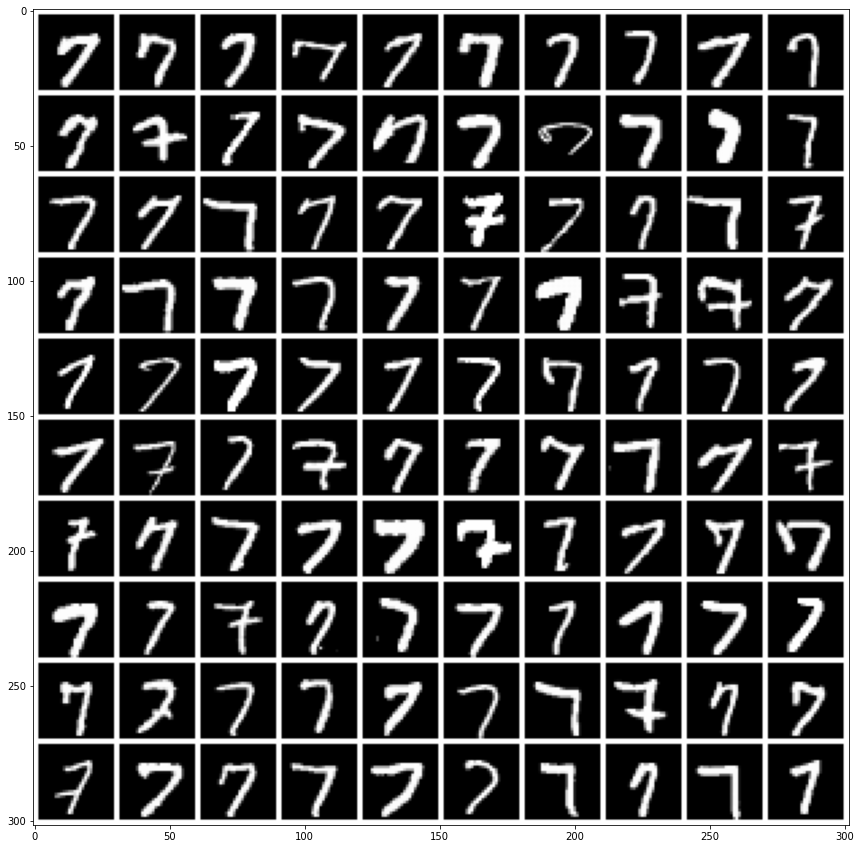

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

Image Processing 

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=0.1307, std=0.3081),
    transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
])
# ref: https://pytorch.org/hub/pytorch_vision_resnet/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


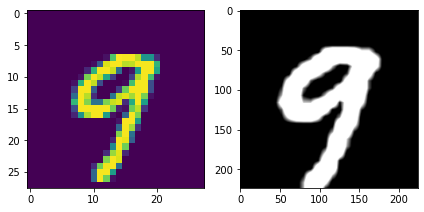

In [ ]:
timg = train_dict[9][5]  # shape = (1,28,28)
ptimg = preprocess(timg)  # shape = (3,224,224)7
_, axarr = plt.subplots(1,2, figsize = (7,7)) 

axarr[0].imshow(timg.squeeze())

axarr[1].imshow(torch.movedim(ptimg, -3, -1))
#ref : https://pytorch.org/docs/stable/generated/torch.movedim.html

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


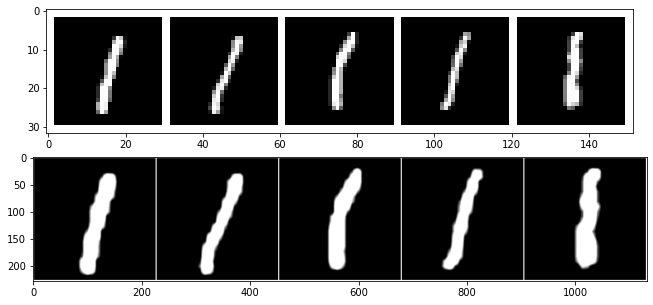

In [ ]:
rand_imgs = train_dict[1][random.sample(range(1, 5000), 5)]  # shape = (5,1,28,28)
grid = torchvision.utils.make_grid(rand_imgs, nrow=5, pad_value=20)

prand_imgs = preprocess(rand_imgs)  # shape = (5,3,224,224)
pgrid = torchvision.utils.make_grid(prand_imgs, nrow=5, pad_value=20)

fig , axarr = plt.subplots(2,1, figsize = (15,5)) 

axarr[0].imshow(np.transpose(grid, (1,2,0)))
axarr[1].imshow(np.transpose(pgrid, (1,2,0)))

In [ ]:
IMAGES = {0:train_dict[0][95], 1:train_dict[1][1], 2:train_dict[2][2], 3:train_dict[3][0]}
for i in range(4,9):
    IMAGES[i] = train_dict[i][1]
IMAGES[9] = train_dict[9][5]

# Creating Model

In [ ]:
# Self defined CNN Model


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.preprocess = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            transforms.Normalize(mean=0.1307, std=0.3081),
                            transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
                        ])
        # ref: https://pytorch.org/hub/pytorch_vision_resnet/

        self.convnet1 = nn.Sequential(
                            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2),
                            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.convnet2 = nn.Sequential(
                            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.convnet3 = nn.Sequential(
                            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2),
                            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.FCs      = nn.Sequential(
                            nn.Linear(in_features=4096, out_features=2048), nn.ReLU(),
                            nn.Linear(in_features=2048, out_features=512), nn.ReLU(),
                            nn.Linear(in_features=512, out_features=128), nn.ReLU()
        )
        self.out      = nn.Linear(in_features=128, out_features=2)


    def forward(self, x):
        x = self.preprocess(x)
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        x = x.reshape(-1, 4*4*256)
        x = self.FCs(x)
        enc = self.out(x)
        return enc

        

In [ ]:
'''
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.preprocess = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            transforms.Normalize(mean=0.1307, std=0.3081),
                            transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
                        ])
        # ref: https://pytorch.org/hub/pytorch_vision_resnet/

        self.resnet18 = torchvision.models.resnet18(pretrained=False)
        self.out = nn.Linear(in_features=1000, out_features=128)

    def forward(self, images):
        images = self.preprocess(images)
        images = self.resnet18(images)
        encodings = self.out(images)

        return encodings
'''


'\nclass Model(nn.Module):\n    def __init__(self):\n        super(Model, self).__init__()\n        self.preprocess = transforms.Compose([\n                            transforms.Resize(256),\n                            transforms.CenterCrop(224),\n                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),\n                            transforms.Normalize(mean=0.1307, std=0.3081),\n                            transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),\n                        ])\n        # ref: https://pytorch.org/hub/pytorch_vision_resnet/\n\n        self.resnet18 = torchvision.models.resnet18(pretrained=False)\n        self.out = nn.Linear(in_features=1000, out_features=128)\n\n    def forward(self, images):\n        images = self.preprocess(images)\n        images = self.resnet18(images)\n        encodings = self.out(images)\n\n        return encodings\n'

# Visualizing Model

In [ ]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FCs): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
   

In [ ]:
!pip install torchviz

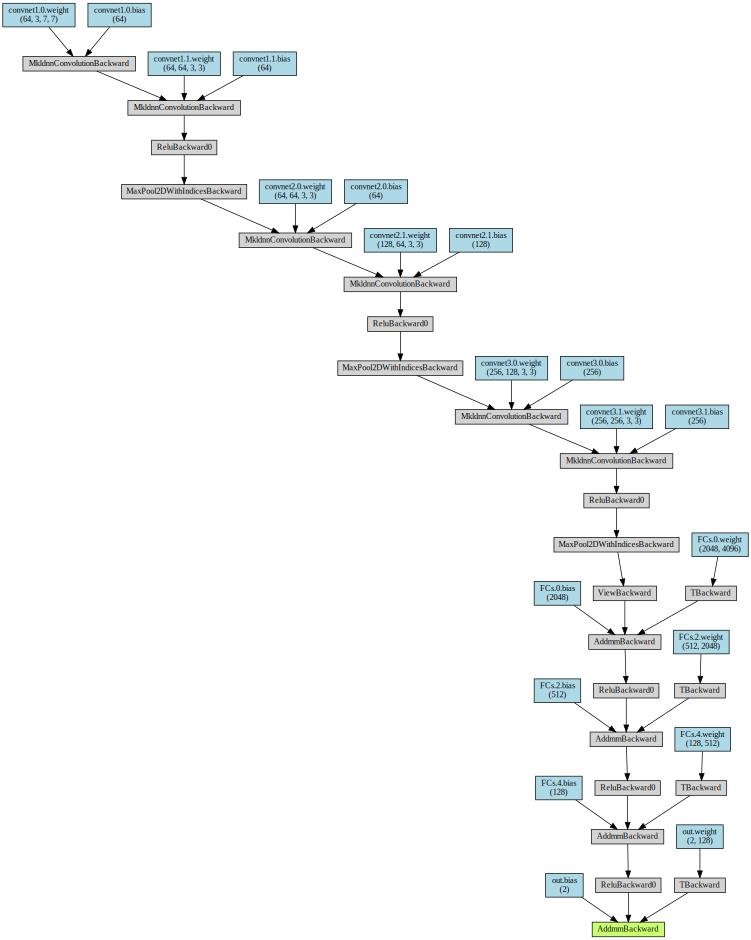

In [ ]:
from torchviz import make_dot

x = torch.randn(10,1,28,28)

make_dot(model(x), params=dict(model.named_parameters()))   

# ref : https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb

In [ ]:
!pip install git+https://github.com/waleedka/hiddenlayer.git

  Cloning https://github.com/waleedka/hiddenlayer.git to /tmp/pip-req-build-s_ag1uuw
  Running command git clone -q https://github.com/waleedka/hiddenlayer.git /tmp/pip-req-build-s_ag1uuw
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-cp36-none-any.whl size=19771 sha256=1fa64e5cd14c48fbf16b3a5545cd11885dcf226f329591bd6747d0b2d9e112ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-vmklreg4/wheels/49/bc/d1/938073704abdd049b3e4cdc6811c8f468d69fb5eecc6e01748
Successfully built hiddenlayer


/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:267: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  "" + str(_export_onnx_opset_version) + ". "


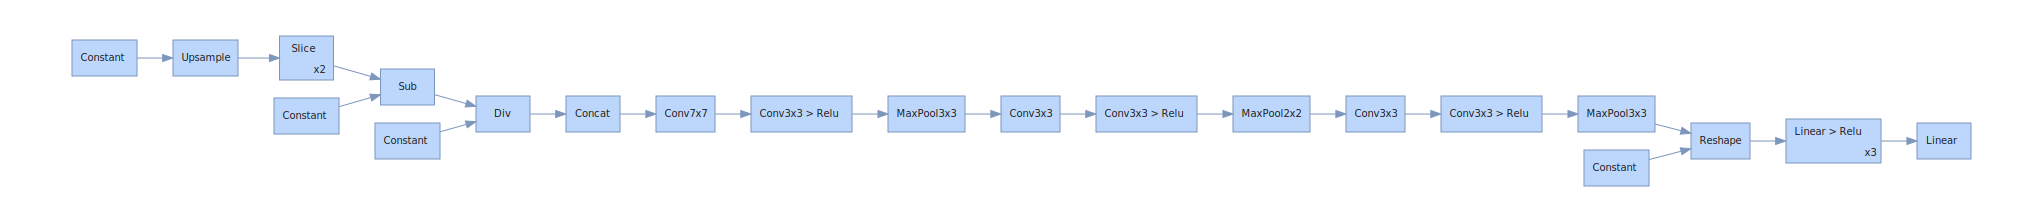

In [ ]:
import hiddenlayer as hl

# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]))

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

#ref : https://github.com/waleedka/hiddenlayer/blob/master/demos/pytorch_graph.ipynb

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
 
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(3):
        plt.scatter(embeddings[i].detach().numpy()[:,0],embeddings[i].detach().numpy()[:,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(targets)

# ref: https://github.com/adambielski/siamese-triplet/blob/master/Experiments_MNIST.ipynb

# Running the Model

In [ ]:
def weights_init(layer):
    classname = layer.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(layer.weight.data, nonlinearity='relu')  # He-initialization
        # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
        
# Reference : https://discuss.pytorch.org/t/weight-initilzation/157

In [ ]:
model = Model()
model.apply(weights_init)

learning_rate = 0.001
lossfn = triplet_loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


In [ ]:
zeros_images = train_dict[0][:100]
ones_images  = train_dict[1][:100]
twos_images  = train_dict[2][:100]

images = torch.stack([zeros_images, ones_images, twos_images], dim=1)
images.shape  # images[:,0,...].shape = torch.Size([100, 1, 28, 28])

torch.Size([100, 3, 1, 28, 28])

In [ ]:
loader = torch.utils.data.DataLoader(images, batch_size=10)
len(loader)
# sample = next(iter(loader))
# sample.shape = torch.Size([10, 3, 1, 28, 28])

10

In [ ]:
enc0 = []
enc1 = []
enc2 = []
for batch in tqdm(loader):
    enc0.append(model(batch[:,0,...]))
    enc1.append(model(batch[:,1,...]))
    enc2.append(model(batch[:,2,...]))
enc0 = torch.cat(enc0)
enc1 = torch.cat(enc1)
enc2 = torch.cat(enc2)
enc0.shape, enc1.shape, enc2.shape

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


(torch.Size([100, 2]), torch.Size([100, 2]), torch.Size([100, 2]))

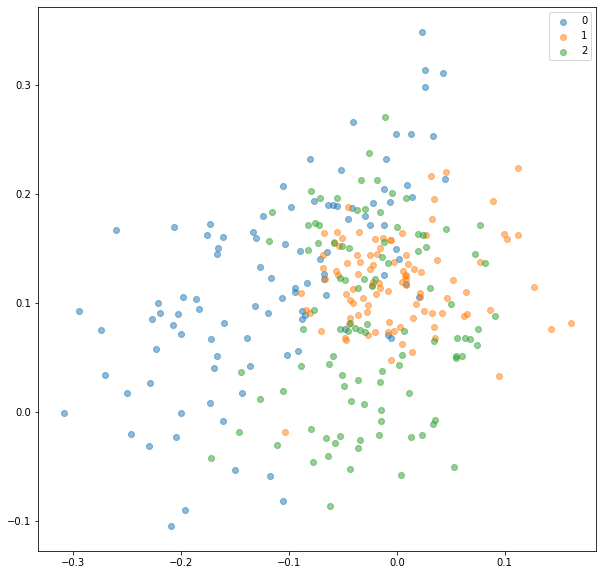

In [ ]:
plot_embeddings(embeddings=[enc0, enc1, enc2], targets=[0,1,2])

In [ ]:
# zeros_images = train_dict[0][:100]
# ones_images  = train_dict[1][:100]
# twos_images  = train_dict[2][:100]

# triplets = get_random_triplets([zeros_images, ones_images, twos_images], [0, 1, 2])

# cost = []

# epochs = 5
# for epoch in range(epochs):
#     anchor    = model(triplets[:,0,...])
#     positive  = model(triplets[:,1,...])
#     negative  = model(triplets[:,2,...])

#     optimizer.zero_grad()
#     loss = lossfn(anchor, positive, negative, margin=1)
#     cost.append(loss)

    
#     loss.backward(retain_graph=True)
#     optimizer.step()

#     print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')


In [ ]:
cost = []

epochs = 5
for epoch in range(epochs):
    for batch in loader:
        zeros_encodings = model(batch[:,0,...])
        ones_encodings  = model(batch[:,1,...])
        twos_encodings  = model(batch[:,2,...])

        triplets = get_random_triplets([zeros_encodings, ones_encodings, twos_encodings], [0, 1, 2])

        anchor   = triplets[:,0]
        positive = triplets[:,1]
        negative = triplets[:,2]

        optimizer.zero_grad()
        loss = lossfn(anchor, positive, negative, margin=1)
        cost.append(loss)

        
        loss.backward()
        optimizer.step()

        print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')


Epoch:[1/5] , Cost : 0.9867097735404968
Epoch:[1/5] , Cost : 1.328707218170166
Epoch:[1/5] , Cost : 3.049072504043579
Epoch:[1/5] , Cost : 0.4129650294780731
Epoch:[1/5] , Cost : 0.24572953581809998
Epoch:[1/5] , Cost : 0.23649337887763977
Epoch:[1/5] , Cost : 0.45024359226226807
Epoch:[1/5] , Cost : 3.0533065795898438
Epoch:[1/5] , Cost : 0.027214672416448593
Epoch:[1/5] , Cost : 1.669111728668213
Epoch:[2/5] , Cost : 5.153902530670166
Epoch:[2/5] , Cost : 1.8816169500350952
Epoch:[2/5] , Cost : 0.25409644842147827
Epoch:[2/5] , Cost : 0.4479537904262543
Epoch:[2/5] , Cost : 0.1859135925769806
Epoch:[2/5] , Cost : 0.031168051064014435
Epoch:[2/5] , Cost : 0.45338761806488037
Epoch:[2/5] , Cost : 0.3937654197216034
Epoch:[2/5] , Cost : 0.25389644503593445
Epoch:[2/5] , Cost : 0.6581199169158936
Epoch:[3/5] , Cost : 0.2539158761501312
Epoch:[3/5] , Cost : 0.18715576827526093
Epoch:[3/5] , Cost : 0.10627774894237518
Epoch:[3/5] , Cost : 0.1602085381746292
Epoch:[3/5] , Cost : 0.193270206

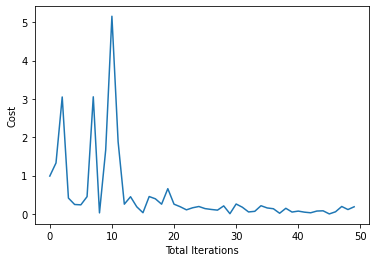

In [ ]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(epochs*len(loader)), cost)
plt.show()

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


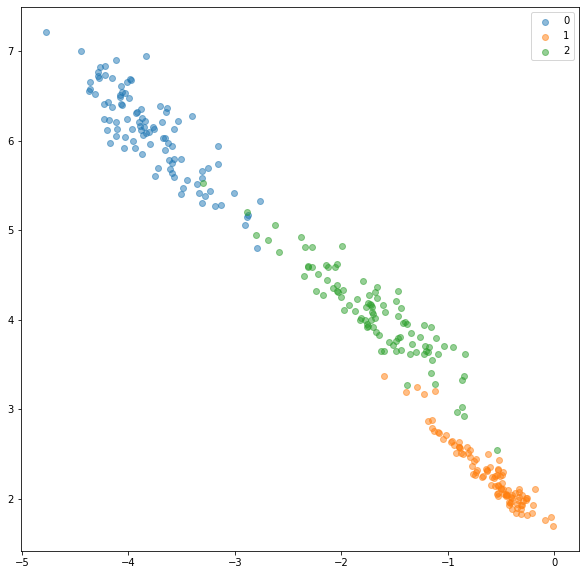

In [ ]:
enc0 = []
enc1 = []
enc2 = []
for batch in tqdm(loader):
    enc0.append(model(batch[:,0,...]))
    enc1.append(model(batch[:,1,...]))
    enc2.append(model(batch[:,2,...]))
enc0 = torch.cat(enc0)
enc1 = torch.cat(enc1)
enc2 = torch.cat(enc2)
plot_embeddings([enc0, enc1, enc2], [0,1,2])

In [ ]:
enc0.shape , enc1.shape, enc2[0].shape

(torch.Size([100, 2]), torch.Size([100, 2]), torch.Size([2]))

In [ ]:
(enc0 - enc1).pow(2).sum(-1)

tensor([26.1237, 29.8583, 30.3116, 26.6095, 32.6504, 28.9747, 30.9447, 31.6974,
        19.5662, 14.6846, 25.9073, 28.5286, 33.6150, 31.4949, 33.1447, 30.1173,
        14.4130, 32.7337, 21.1432, 28.6539, 28.0645, 26.3081, 31.3550, 30.0861,
        33.8194, 32.4767, 23.3815, 24.4337, 18.0497, 36.9826, 15.0644, 25.4634,
        22.9539, 23.2618, 32.5882, 28.7088, 28.6660, 40.2479, 25.7379, 27.2440,
        37.4510, 38.3124, 29.4411, 22.2152, 20.5440, 34.8775, 30.8872, 32.9536,
        12.8041,  9.6216, 21.5775, 33.1834, 30.1523, 20.9399, 29.0360, 20.9687,
        29.0641, 34.0425, 27.0221, 38.9128, 22.8589, 12.3453, 32.1422, 33.7708,
        26.3017, 13.9369, 29.7363, 21.6747, 18.6773, 21.8077, 22.2164, 22.4034,
        24.2658, 24.6175, 16.5985, 22.3633, 26.5015, 19.9653, 23.9109, 38.2693,
        20.5445, 32.2025, 16.5843, 32.1046, 19.6157, 25.1603, 16.0444, 16.5427,
        19.2548,  8.6091, 16.1372, 20.9143, 20.7647, 15.7792, 13.3203, 28.2498,
        17.7087, 17.8901, 14.0515, 18.75

In [ ]:
(enc0 - enc2).pow(2).sum(-1)

tensor([ 9.8807, 13.3406,  6.0950, 12.1612, 10.0270, 14.2366,  3.5556,  3.9359,
        17.8565, 13.0694,  4.0369,  6.3262,  6.5457,  3.4181,  7.1626, 25.6511,
         0.1174,  3.1158,  2.6152,  8.4270,  8.5892, 15.5855, 14.6992,  8.8020,
        16.3962,  5.3742,  6.5919, 16.4080,  4.8238, 12.4332,  2.0597, 15.3490,
        11.0705, 10.7062,  6.5756, 13.8305, 11.0088, 11.5209, 11.7078,  7.5511,
        12.4172, 20.7888,  6.1136,  6.7358, 13.9333, 26.0270, 19.4445, 13.8572,
         5.5514,  4.4895,  7.4728, 10.9954,  9.4390,  9.7242, 10.9347,  5.6252,
        16.1451,  9.9657, 12.8556, 23.3780,  5.1204, 10.3331, 18.1123, 10.1479,
        10.8809,  9.0992, 15.1841,  9.7947,  8.7594,  8.9864,  9.2529,  8.9704,
        10.6550,  9.7341,  1.8156,  8.9884,  7.4767,  5.6754,  7.5293, 14.0655,
         6.3441,  9.0398,  3.8942,  9.8273,  4.1319,  4.7585,  2.6104,  0.9725,
        10.6526,  0.4216,  4.3772, 13.3994,  4.0217,  2.6930,  5.1380, 13.7519,
         3.1574,  7.0165,  5.2453,  9.82

In [ ]:
(enc1 - enc2).pow(2).sum(-1)

tensor([ 3.9057,  3.8921,  9.8989,  3.1510,  6.5876,  2.7584, 13.6977, 13.4160,
         0.1501,  0.1689,  9.7252,  8.1818, 10.7047, 14.1635, 10.1778,  0.2543,
        12.1407, 15.6518,  8.8978,  6.3558,  5.7383,  1.8677,  3.2024,  6.3724,
         3.4562, 11.4299,  5.2039,  1.0071,  4.3546,  6.7278,  5.9865,  1.3157,
         2.4190,  2.6395, 10.0140,  3.0365,  4.3872,  9.2101,  2.9116,  6.1987,
         6.8120,  2.6592,  8.7916,  4.7099,  1.1531,  0.6953,  1.3830,  4.1923,
         1.5892,  1.1687,  4.0282,  6.3482,  6.0165,  2.9225,  4.7407,  5.3108,
         2.0202,  7.1740,  2.9261,  2.2584,  6.3694,  0.3903,  2.0734,  7.1101,
         3.4963,  0.7250,  2.4672,  2.4091,  2.3324,  2.8000,  2.8087,  3.1938,
         3.2972,  3.5518,  7.5268,  3.5016,  5.8840,  4.4308,  4.6284,  6.0435,
         4.6053,  7.1953,  4.4967,  6.5246,  6.1629,  8.1883,  6.0539,  9.6775,
         1.4148,  5.5246,  4.6427,  1.3095,  6.8385,  5.5456,  2.0678,  2.6796,
         6.1522,  2.5920,  2.2174,  1.88

In [ ]:
IMAGES_ENC = {k:model(v.unsqueeze(0)) for k,v in IMAGES.items()}


In [ ]:
(0.36 + 0.97 + 1.17) / 3

0.8333333333333334

In [ ]:
correct = {i:0 for i in range(3)}
for k , value in train_dict.items():
    vload = torch.utils.data.DataLoader(value, batch_size=10)
    for v in tqdm(vload, desc=f"Class : {k}", position=0, leave=True):
        correct[k] += ((model(v) - IMAGES_ENC[k]).pow(2).sum(-1) < 0.833).sum()

In [92]:
print(f'Accuracy on Class 0 is {correct[0].sum() / train_dict[0].shape[0] * 100} %')

Accuracy on Class 0 is 51.621620178222656 %


In [87]:
train_dict[0].shape[0]

5923

## Random Testings

In [70]:
a = torch.rand(100,1,28,28)
b = torch.rand(100,1,28,28)
c = torch.rand(100,1,28,28)

In [ ]:
trp = get_all_tensor_triplets([a,b,c], (1,2,3))

In [ ]:
trp.shape

In [ ]:
trp[:,0,...].shape

In [ ]:
trp_loader = torch.utils.data.DataLoader(rt, batch_size=20)

In [ ]:
torch.cat([i for i in trp_loader]).shape

In [ ]:
len(trp_loader)

In [ ]:
for i in trp_loader:
    print(i.shape)

In [ ]:
rt = get_random_triplets([a,b,c], [1,2,3])

In [ ]:
rt.shape

In [ ]:
a = torch.rand(5,3,4)*10
print(a.shape)
a

In [74]:
a = torch.rand(10,2)
p = torch.rand(10,2)
n = torch.rand(10,2)
a,p,n

(tensor([[0.7896, 0.5158],
         [0.2877, 0.5015],
         [0.2847, 0.8324],
         [0.3608, 0.9372],
         [0.3799, 0.1717],
         [0.7204, 0.1638],
         [0.1053, 0.5174],
         [0.9763, 0.1723],
         [0.2700, 0.9597],
         [0.4850, 0.7582]]), tensor([[0.5777, 0.4946],
         [0.2587, 0.6608],
         [0.0787, 0.1402],
         [0.0453, 0.0809],
         [0.0551, 0.8875],
         [0.7819, 0.1165],
         [0.8714, 0.5869],
         [0.2256, 0.8397],
         [0.2104, 0.6884],
         [0.4457, 0.6710]]), tensor([[0.4039, 0.4526],
         [0.4207, 0.9289],
         [0.1743, 0.2661],
         [0.2000, 0.2397],
         [0.8647, 0.6910],
         [0.4609, 0.4615],
         [0.5447, 0.4576],
         [0.7223, 0.7270],
         [0.9221, 0.7951],
         [0.7925, 0.8124]]))

In [80]:
(a<0.3).sum()

tensor(7)

In [ ]:
t = get_triplets([a,p,n], [0,1,2])
len(t)
# type(t[2699])
# len(t[2699][0])
# type(t[2699][0])
for _ in t: print(_, end="\n\n")

In [ ]:
tt = get_tensor_triplets([a,p,n], [0,1,2])

In [ ]:
type(tt)
tt.shape
# tt[:,0].shape
tt[:,0] #.shape

In [ ]:
exp = torch.rand(2700,1,28,28)
m = Model()

In [ ]:
t = m(exp)
t.shape

In [ ]:
t = m.convnet2(t)
t.shape

In [ ]:
t = m.convnet3(t)
t.shape

In [ ]:
t1 = t.reshape(-1, 4096)
t1.shape

In [ ]:
t1 = m.FCs(t1)
t1.shape

In [ ]:
t1 = m.out(t1)
t1.shape

In [ ]:
t.shape